In [1]:
!git clone https://github.com/Jsrsky/machine_unlearning_experiments
%cd machine_unlearning_experiments/experiments/animal_faces/naive

Cloning into 'machine_unlearning_experiments'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 368 (delta 39), reused 82 (delta 19), pack-reused 222 (from 2)
Receiving objects: 100% (368/368), 229.55 MiB | 40.92 MiB/s, done.
Resolving deltas: 100% (115/115), done.
Updating files: 100% (79/79), done.
/kaggle/working/machine_unlearning_experiments/experiments/animal_faces/naive


## Dependecies

In [2]:
import sys
from pathlib import Path
from torchvision import datasets

## Utils

In [3]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


# DELETE IF GOING FOR LOCAL SETUP, ADD AHFQ DATASET TO "./data" FOLDER

In [4]:
data_root = Path('/kaggle/input/animal-faces')

In [5]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

# Prepare Dataloaders
from methods.naive.naive_utils import init_dataloaders

# Train loop
from utils.train_test_metrics import train_model

# Plot losses
from utils.train_test_metrics import plot_training_history

# Test function
from utils.train_test_metrics import test_model

# Merics 
from utils.train_test_metrics import show_metrics

# Init model
from models.effnetb0 import init_model_effnetb0

Device used: cuda


## Parameters (arbitrary chosen)

In [14]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 3

# Simple base training

## Init model

In [15]:
model, model_name, criterion, optimizer, transform = init_model_effnetb0(learning_rate=LEARNING_RATE, fc_output=3)

Init model...
Done initializing model.
Model ID: 137407102378256, Optimizer ID: 137407102378064, Criterion ID: 137407102377728


## Init dataloaders

In [16]:
train_dataset = datasets.ImageFolder(root=data_root/'afhq/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_root/'afhq/val', transform=transform)
data_split_path = 'afhq_data_splits.json'

train_loader, val_loader, test_loader, classes = init_dataloaders(
    datasets=(train_dataset, test_dataset),
    val_ratio=0.2,
    batch_size=BATCH_SIZE,
    info_file_path = data_split_path,
    )

Prepare DataLoaders...
Done preparing DataLoaders.


## Call train

In [17]:
import time
start_time = time.perf_counter()
train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS)
end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Evaluating on validation set...: 100%|██████████| 46/46 [00:26<00:00,  1.72it/s]


Epoch [1/3], Train Loss: 0.0560, Train Accuracy: 0.9839, Val Loss: 0.0149, Val Accuracy: 0.9952
Epoch 1: New best validation accuracy: 0.9952. Model saved to EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 46/46 [00:24<00:00,  1.91it/s]


Epoch [2/3], Train Loss: 0.0150, Train Accuracy: 0.9947, Val Loss: 0.0490, Val Accuracy: 0.9843


Evaluating on validation set...: 100%|██████████| 46/46 [00:24<00:00,  1.84it/s]

Epoch [3/3], Train Loss: 0.0167, Train Accuracy: 0.9946, Val Loss: 0.0246, Val Accuracy: 0.9932
Training complete for EffNetB0_AFHQ. Training stats saved to 'EffNetB0_AFHQ_history.json'.
Execution time: 509.950064 seconds


## Plot history losses

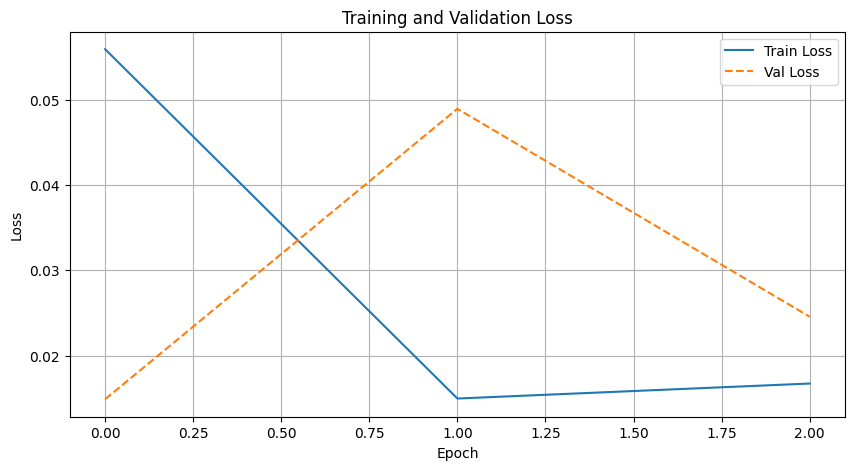

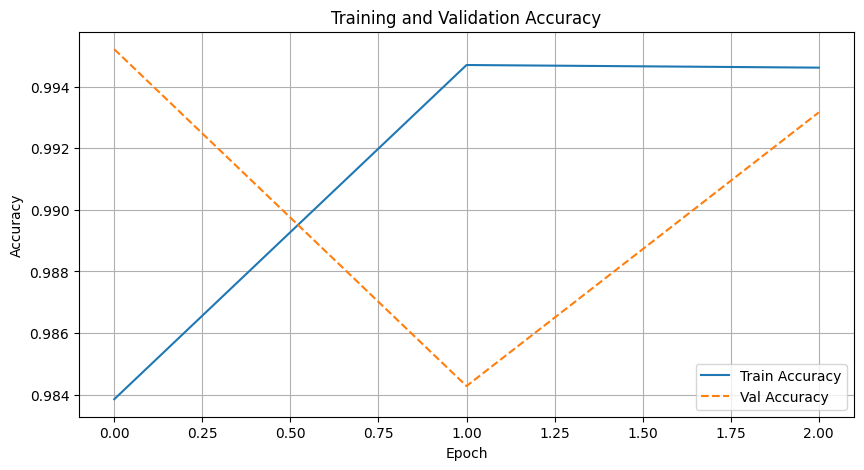

In [18]:
history_path = f'{model_name}_history.json'
plot_training_history(history_path)

## Call test

In [19]:
model_path = f"{model_name}_model.pth"
test_model(model, model_name, model_path, test_loader)

Loading and testing model: EffNetB0_AFHQ


Evaluating model: EffNetB0_AFHQ_model.pth: 100%|██████████| 24/24 [00:13<00:00,  1.81it/s]

Predictions and labels saved to EffNetB0_AFHQ_predictions.json


## Show metrics

Metrics for EffNetB0_AFHQ:
  - Test Accuracy: 0.9980
  - Precision: 0.9980
  - Recall: 0.9980
  - F1 Score: 0.9980


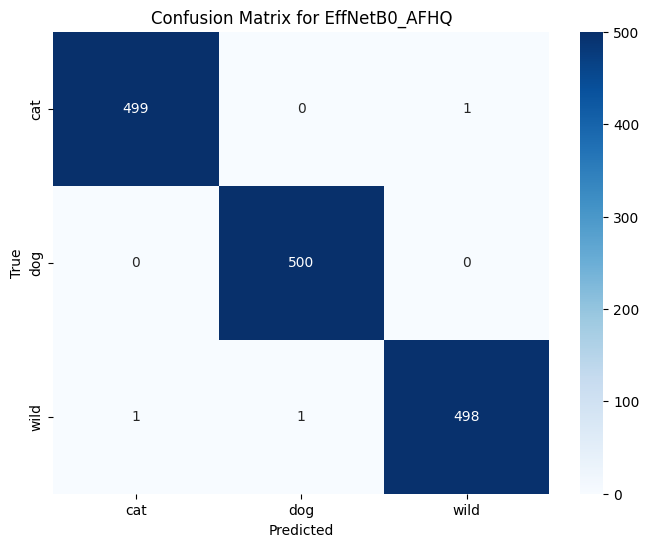

In [20]:
predictions_path = f'{model_name}_predictions.json'
#classes = ['cat', 'dog', 'wildlife']
show_metrics(predictions_path, classes, model_name)

## Utils naive

In [21]:
# Select samples to unlearn (10% random)
from utils.utils import select_samples_to_unlearn

# Update data splits
from methods.naive.naive_utils import update_splits_after_unlearning

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# Naive unlearning

### Init new model

In [55]:
data_splits_file = "afhq_data_splits.json"
unlearn_samples_file = "afhq_samples_to_unlearn_20per.json"
updated_data_splits_path = "updated_afhq_data_splits.json"

In [56]:
model, model_name, criterion, optimizer, transform = init_model_effnetb0(learning_rate=LEARNING_RATE, fc_output=3)
model_name = "naive_unlearning_" + model_name

Init model...
Done initializing model.
Model ID: 137407073310352, Optimizer ID: 137407514066848, Criterion ID: 137407101851856


### Init data

In [57]:
train_dataset = datasets.ImageFolder(root=data_root/'afhq/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_root/'afhq/val', transform=transform)

## Select samples to unlearn

In [58]:
#ONLY ONCE
select_samples_to_unlearn(data_splits_file, unlearn_samples_file, unlearn_ratio=0.2)

Unlearn indices saved to afhq_samples_to_unlearn_20per.json


## Update data splits -> delete samples

In [59]:
update_splits_after_unlearning(data_splits_file, unlearn_samples_file, updated_data_splits_path)

Updated splits saved to updated_afhq_data_splits.json


## Recreate DataLoaders from json files

In [60]:
train_loader, val_loader, test_loader, classes = recreate_dataloaders(
    data_splits_file=updated_data_splits_path,
    datasets=(train_dataset, test_dataset), 
    batch_size=BATCH_SIZE)

Recreating DataLoaders...
Done recreating DataLoaders.


## Re-train

In [61]:
import time
start_time = time.perf_counter()
train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS)
end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Evaluating on validation set...: 100%|██████████| 37/37 [00:19<00:00,  1.88it/s]


Epoch [1/3], Train Loss: 0.0658, Train Accuracy: 0.9799, Val Loss: 0.0354, Val Accuracy: 0.9907
Epoch 1: New best validation accuracy: 0.9907. Model saved to naive_unlearning_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 37/37 [00:19<00:00,  1.86it/s]


Epoch [2/3], Train Loss: 0.0214, Train Accuracy: 0.9940, Val Loss: 0.0201, Val Accuracy: 0.9937
Epoch 2: New best validation accuracy: 0.9937. Model saved to naive_unlearning_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 37/37 [00:19<00:00,  1.89it/s]

Epoch [3/3], Train Loss: 0.0180, Train Accuracy: 0.9940, Val Loss: 0.0298, Val Accuracy: 0.9928
Training complete for naive_unlearning_EffNetB0_AFHQ. Training stats saved to 'naive_unlearning_EffNetB0_AFHQ_history.json'.
Execution time: 403.810419 seconds


## Plot history losses

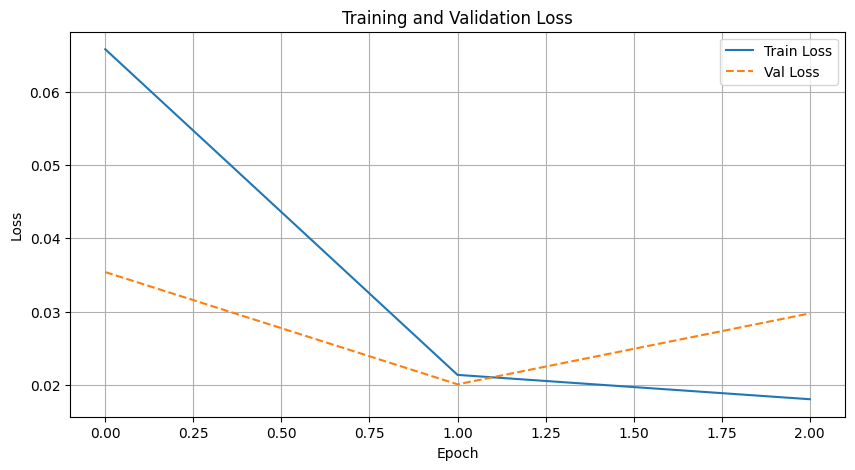

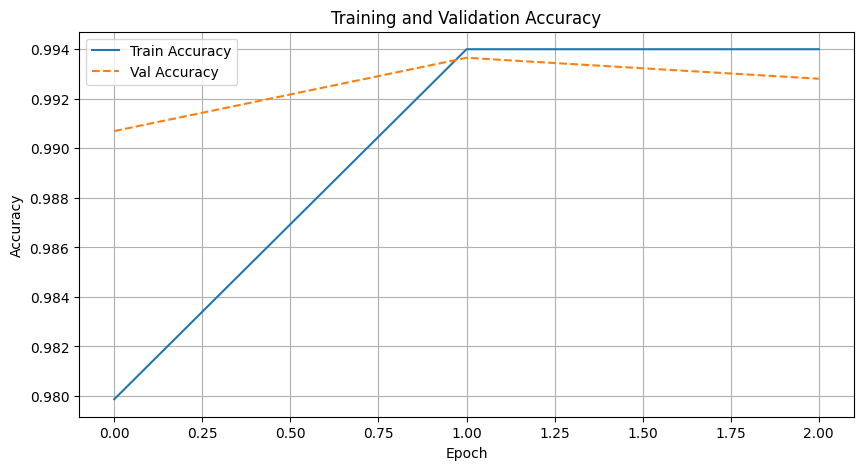

In [62]:
history_path = f'{model_name}_history.json'
plot_training_history(history_path)

## Re-test

In [63]:
model_path = f"{model_name}_model.pth"
test_model(model, model_name, model_path, test_loader)

Loading and testing model: naive_unlearning_EffNetB0_AFHQ


Evaluating model: naive_unlearning_EffNetB0_AFHQ_model.pth: 100%|██████████| 24/24 [00:12<00:00,  1.88it/s]

Predictions and labels saved to naive_unlearning_EffNetB0_AFHQ_predictions.json


## Show metrics

Metrics for naive_unlearning_EffNetB0_AFHQ:
  - Test Accuracy: 0.9967
  - Precision: 0.9967
  - Recall: 0.9967
  - F1 Score: 0.9967


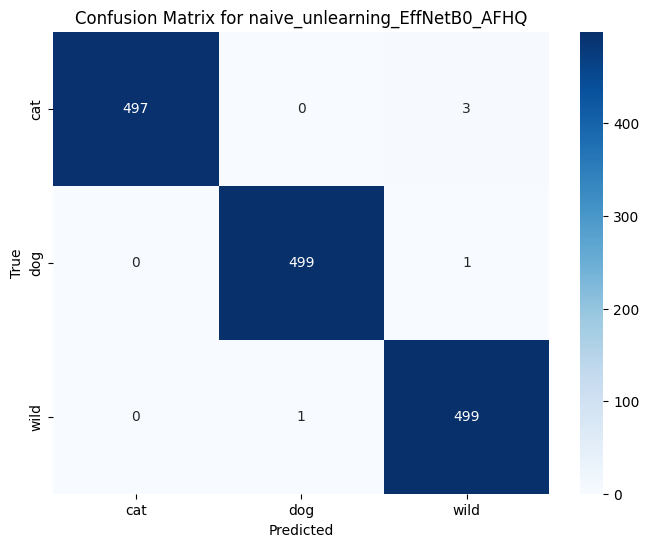

In [64]:
predictions_path = f'{model_name}_predictions.json'
#classes = ['cat', 'dog', 'wildlife']
show_metrics(predictions_path, classes, model_name)